In [2]:
import pigpio
import math
from time import sleep
import numpy as np
import math
import matplotlib.pyplot as plt
import copy

In [3]:
class TLV493D:
    
    """Class of 3D Magnetic Sensor TLV493D.
    """
                                                                                                                                                      
      
    bx = 0
    by = 0
    bz = 0 
    temp = 0
    data =[]
    pi = pigpio.pi()

    addr = 0x35
    channel = 1
    
    
    h = pi.i2c_open(channel, addr)
    (count, data) = pi.i2c_read_device(h, 23)
    print(count,"             ",data)
    
    
    

    def initialize(self): 
        """ Read data from register
        """
        global data
        
        self.pi.i2c_write_byte_data(self.h, 0x11, 21)
        self.pi.i2c_write_byte_data(self.h, 0x10, 32)
        sleep(60e-6)
        (count, data) = self.pi.i2c_read_device(self.h, 23)
        print(data) 
        
    def initialize_FM(self):
        self.pi.i2c_write_byte_data(self.h, 0x11, 0x13)
        self.pi.i2c_write_byte_data(self.h, 0x10, 0x00)
        sleep(60e-6)
        
    def update_data (self):
        global data
        (count, data) = self.pi.i2c_read_device(self.h, 6)
        # print(data)
        
    def get_x(self):
        """ Get the value of X coordinate
            
            Returns:
            
            int: X coordinate
        """
        
        self.bx = (data[0] << 4) or ((data[4] >> 4) & 0x0f)
        
        if self.bx > 2047:
            
            self.bx -= 4096
        self.bx *=0.098
            
        return self.bx
    
    
    
    
    def get_y(self):
        """ Get the value of Y coordinate
            
            Returns:
            
            int: Y coordinate
        """
        self.by = data[1] << 4 or data[4] & 0x0f

        
        if self.by > 2047:
            
            self.by -= 4096
        self.by *=0.098
            
        return self.by
    
    
    
    
    def get_z(self):
        """ Get the value of Z coordinate
            
            Returns:
            
            int: Z coordinate
        """
        
        self.bz = data[2] << 4 or data[5] & 0x0f
        
        if self.bz > 2047:
            
            self.bz -= 4096
        self.bz *=0.098
            
        return self.bz
    
    
    
    def get_br(self):
        """ Calculate the radial value
            
            Returns:
            
            double : radial value
        """
        
        br = math.sqrt(self.bx*self.bx+self.by*self.by+self.bz*self.bz)
        
        return br
    
    
    
    
    def get_polar(self):
        """ Calculate the polar value
            
            Returns:
            
            double: polar value
        """
        
        polar = math.cos(math.atan2(self.bz,math.sqrt(self.bx*self.bx+self.by*self.by)))
        
        return polar
    
    
    
    
    def get_azimuth(self):
        """ Calculate the azimuthal value
            
            Returns:
            
            double: azimuthal value
        """
        
        azimuth = math.atan2(self.by,self.bx)
        
        return azimuth
  


23               bytearray(b'\xfa\x04\xffIZ\xc1b\x80\x7f\x80\x7f\x80\x7f888\x00\x134\x00\xff\xff\xc9')


In [21]:
mat = np.zeros((1,6),dtype=np.float64)
mat_flattened = np.zeros((1,18000),dtype = np.float64)
tlv493d = TLV493D()
tlv493d.initialize()
# tlv493d.initialize_FM()
#for i in range (4000):
cnt = 0
while True:
    
    tlv493d.update_data()
    x = tlv493d.get_x()
    y = tlv493d.get_y()
    z = tlv493d.get_z()
    r = tlv493d.get_br()
    # r = math.sqrt(x*x + y*y)
    theta = tlv493d.get_polar() 
    azi = tlv493d.get_azimuth()
    mat = np.vstack((mat, [x, y, z, r, theta, azi]))
    # print("x: ", x, "y: ", y, "z: ",z)
    # if (((x>0.26) and (x<300)) and ((y>0.26) and (y<300))):
    #     mat = np.vstack((mat, [x, y, z]))
    #     # print("x: ", x, "y: ", y, "z: ",z)
    (mat_r, mat_c) = mat.shape
    sleep (200e-6)
    if (((mat_r)%3000)==0):
        temp = copy.deepcopy(mat[mat_r-3000:mat_r,:])
        temp.resize(1,18000)
        mat_flattened= np.vstack((mat_flattened, temp))
        plt.polar(mat[mat_r-3000:mat_r,5], mat[mat_r-3000:mat_r,4])
        plt.savefig("./Images/data{}".format(cnt))
        plt.clf()
        sleep(1)
        print(cnt)
        cnt+=1

    


bytearray(b'\xfc\x05\xfeK\xe8MM\x80\x7f\x80\x7f\x80\x7f888 \x154\x00\xff\xff\xc9')
0
1
2
3
4


KeyboardInterrupt: 

<Figure size 432x288 with 0 Axes>

In [12]:
# print(data.shape)
print(type(mat_flattened))
print(type(temp))
print(type(mat))
print(mat_flattened.shape)
mat_flattened.resize(mat.shape)

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(8, 18000)


[[ True  True  True  True  True  True]
 [False False False False False False]
 [False False False False False False]
 ...
 [ True False  True False False False]
 [ True False  True False False False]
 [ True False  True False False False]]


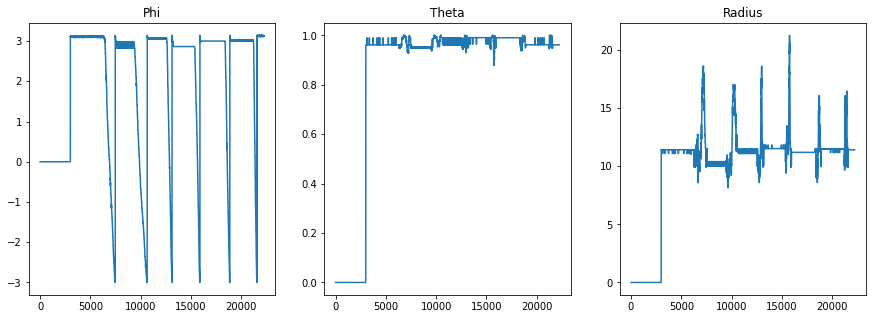

In [14]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,3,  figsize=(15, 5))
ax[0].plot(mat_flattened[:,5])
ax[0].set_title("Phi")
ax[1].plot(mat_flattened[:,4])
ax[1].set_title("Theta")
ax[2].plot(mat_flattened[:,3])
ax[2].set_title("Radius")
 
# Showing the above plot
plt.show()

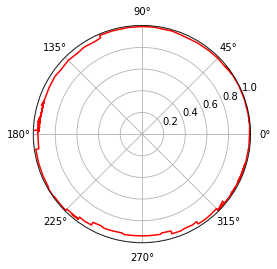

In [10]:
plt.polar(mat[3000:6000,5], mat[3000:6000,4],'r')

/home/pi/mic/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


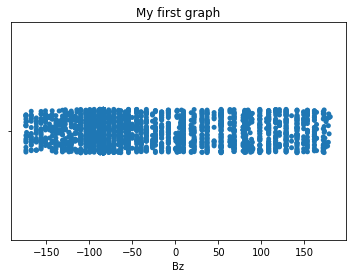

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
 

ax = sns.stripplot(mat[:,5])
 
# giving labels to x-axis and y-axis
ax.set(xlabel ='Bz')
 
# giving title to the plot
plt.title('My first graph')
 
# function to show plot
plt.show()

In [36]:
(r,x) = mat.shape
print (r)

4001


bytearray(b'\x04\x05\xffKc\x87L\x80\x7f\x80\x7f\x80\x7f888 \x154\x00\xff\xff\xc9')


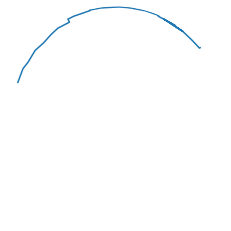

In [10]:
mat = np.zeros((1,6),dtype=np.float64)
mat_flattened = np.zeros((1,18000),dtype = np.float64)
tlv493d = TLV493D()
tlv493d.initialize()
# tlv493d.initialize_FM()
#for i in range (4000):
cnt = 0
for i in range(2999):
    
    tlv493d.update_data()
    x = tlv493d.get_x()
    y = tlv493d.get_y()
    z = tlv493d.get_z()
    r = tlv493d.get_br()
    # r = math.sqrt(x*x + y*y)
    theta = tlv493d.get_polar() 
    azi = tlv493d.get_azimuth()
    mat = np.vstack((mat, [x, y, z, r, theta, azi]))
    # print("x: ", x, "y: ", y, "z: ",z)
    # if (((x>0.26) and (x<300)) and ((y>0.26) and (y<300))):
    #     mat = np.vstack((mat, [x, y, z]))
    #     # print("x: ", x, "y: ", y, "z: ",z)
    (mat_r, mat_c) = mat.shape
    sleep (200e-6)
plt.polar(mat[50:,5], mat[50:,4])
plt.grid(False)
plt.axis("off")
#plt.savefig("./Images/data{}".format(cnt))
plt.show()
    # if (((mat_r)%3000)==0):
    #     temp = copy.deepcopy(mat[mat_r-3000:mat_r,:])
    #     temp.resize(1,18000)
    #     mat_flattened= np.vstack((mat_flattened, temp))
        
    #     sleep(1)
    #     print(cnt)
    #     cnt+=1